In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import numpy as np
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2023-09-24 16:11:16.681867: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-24 16:11:16.730376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mo

2.12.0


In [2]:
## Uso de GPU
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Dataset

In [3]:
### Rutas de todas las imágenes

## Obtener todas las rutas de las imágenes en el dataset
ruta_dataset  = glob.glob('/home/willy98/archivos/Datasets/SH_procesadas/Recortadas_grises/*/*/*/*.jpg')

## Capturar solo rutas secas 
rutas_imagenes_secas = []
rutas_imagenes_humedas = []

clases_secas= []
clases_humedas = []
for ruta in ruta_dataset:
    if ruta.split('/')[-2] == 'Secas' or ruta.split('/')[-2] == 'Seca':
        clases_secas.append(ruta.split('/')[-4])
        rutas_imagenes_secas.append(ruta)
    else:
        clases_humedas.append(ruta.split('/')[-4])
        rutas_imagenes_humedas.append(ruta)

## Construcción de datasets
data_secas = pd.DataFrame({'ruta':rutas_imagenes_secas,'clase':clases_secas})
data_humedas = pd.DataFrame({'ruta':rutas_imagenes_humedas,'clase':clases_humedas})

## reemplazo de etiquetas}
lables_generalization = {'CuNi1':'MF1','CuNi2':'MF2','CuNi3':'MF3'}
data_secas.replace(lables_generalization,inplace=True)
data_humedas.replace(lables_generalization,inplace=True)

## summary    
print('Imágenes secas:', np.shape(rutas_imagenes_secas)[0],' - Imágenes Húmedas: ',np.shape(rutas_imagenes_humedas)[0])
print('MF1:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF1'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF1'])[0])
print('MF2:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF2'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF2'])[0])
print('MF3:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF3'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF3'])[0])

Imágenes secas: 931  - Imágenes Húmedas:  792
MF1: - secas:  379 - húmedas:  265
MF2: - secas:  289 - húmedas:  265
MF3: - secas:  263 - húmedas:  262


In [4]:
## Crear Dataframe
df_secas = pd.DataFrame()
df_secas['routes'] = rutas_imagenes_secas
df_secas['label'] = clases_secas

char_to_num = {'CuNi1':'0','CuNi2':'1','CuNi3':'2'}

df_secas['label'].replace(char_to_num,inplace=True)

## Recolver dataframe
df_secas = df_secas.sample(frac=1,random_state=42).reset_index(drop=True)

In [5]:
## Establecer el porcentaje de separación
thold1 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='0'])))
thold2 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='1'])))
thold3 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='2'])))

## Separar por clases para entrenamiento
train_cu1 = df_secas[df_secas.label == '0'][0:thold1]
train_cu2 = df_secas[df_secas.label == '1'][0:thold2]
train_cu3 = df_secas[df_secas.label == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = df_secas[df_secas.label == '0'][thold1:]
test_cu2 = df_secas[df_secas.label == '1'][thold2:]
test_cu3 = df_secas[df_secas.label == '2'][thold3:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3])

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3])

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  304 , test:  75
Clase MF2: train:  232 , test:  57
Clase MF3: train:  211 , test:  52


In [6]:
## Crear objetos transformadores
## Para entrenamiento
img_generator_training = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

## Crear objeto generador de imágenes a partir del objeto transformator
## Pra entrenamiento
train_generator= img_generator_training.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="routes",
    y_col="label",
    labels = ['MF1','MF2','MF3'],
    subset="training",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

Found 598 validated image filenames belonging to 3 classes.


In [7]:
X_train_secas_expanded = []
y_train_secas_expanded = []

batches = 50
cnt = 0

for i in range(batches):
    
    x,y = train_generator.next()

    X_train_secas_expanded.extend(x)
    y_train_secas_expanded.extend(y)
    
print(np.shape(X_train_secas_expanded),np.shape(y_train_secas_expanded))

(2990, 128, 128, 1) (2990,)


(128, 128, 1)
0.007843138 0.882353


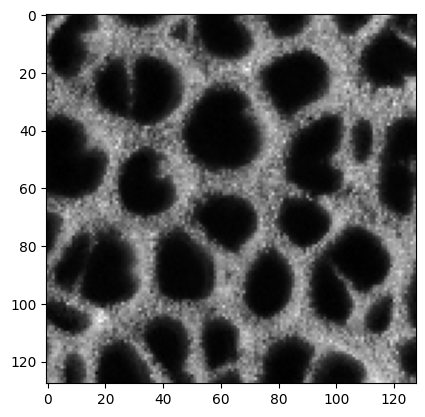

In [8]:
plt.imshow(X_train_secas_expanded[0],cmap='gray')
print(np.shape(X_train_secas_expanded[0]))
print(np.min(X_train_secas_expanded[0]),np.max(X_train_secas_expanded[0]))
plt.show()

In [9]:
## Dataset de prueba
test_df = test_df.sample(frac=1,random_state=42).reset_index(drop=True)

X_test_secas = []
y_test_secas = []

nsize = 128

## Recorrerr rutas
for i in range(len(test_df)):
    
    #Capturar ruta y label
    ruta = test_df.iloc[i].routes
    label = test_df.iloc[i].label
    
    ##cargar imagen
    im = tf.keras.preprocessing.image.load_img(ruta,color_mode='grayscale')
    
    X_test_secas.append(tf.keras.preprocessing.image.img_to_array(im.resize((nsize,nsize))))
    y_test_secas.append(test_df.iloc[i].label)
    
print('Test: train->',np.shape(X_test_secas),' test ->',np.shape(y_test_secas))

Test: train-> (184, 128, 128, 1)  test -> (184,)


In [10]:
x_train_secas_expanded = np.array(X_train_secas_expanded)
x_test_secas = np.array(X_test_secas)

x_train_secas_expanded = x_train_secas_expanded.astype('float32')
x_test_secas= x_test_secas.astype('float32')
 
y_test_secas = tf.keras.utils.to_categorical(y_test_secas)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
x_test_secas /= 255

print('x_train shape:', x_train_secas_expanded.shape)
print('Number of images in x_train', x_train_secas_expanded.shape[0], "y_train:", np.shape(y_train_secas_expanded))
print('Number of images in x_test', x_test_secas.shape, "y_test: ", np.shape(y_test_secas))

x_train shape: (2990, 128, 128, 1)
Number of images in x_train 2990 y_train: (2990,)
Number of images in x_test (184, 128, 128, 1) y_test:  (184, 3)


## VAE

In [12]:
class encoder_block(layers.Layer):
    
    ## Inicializar la clase de capa convolucional
    def __init__(self,out_channels,kernel_size=(3, 3)):
        ## conv y bn son las dos capas (que contienen pesos) del bloque/clase
        super(encoder_block, self).__init__()
        self.conv = layers.Conv2D(out_channels,kernel_size, activation='relu', padding='same')
        self.pooling = layers.MaxPooling2D()
        self.bn = layers.BatchNormalization()       
    
    
    ## The call method is the same as the forward method of the block
    def call(self, input_tensor,training = False):
        x = self.conv(input_tensor)
        x = self.pooling(x)
        x = self.bn(x,training = training)           
        
        return x

    
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
class Encoder(keras.Model):
    
    def __init__(self,name = 'encoder',n_dims=128,**kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)         
        ## Bloque convolucional:
        self.block1 = encoder_block(512)
        self.block2 = encoder_block(256)
        self.block3 = encoder_block(128)
        self.block4 = encoder_block(64)
        self.flattening = layers.Flatten()
        self.z_mean = layers.Dense(n_dims,activation = 'relu')
        self.z_logvar = layers.Dense(n_dims,activation = 'relu')
        self.embedding = Sampling()
        
        
        
    def call(self, tensor_input):
        x = self.block1(tensor_input)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.flattening(x)
        mu = self.z_mean(x)
        logvar = self.z_logvar(x)
        z = self.embedding([mu,logvar])
        
        
        return [mu,logvar,z]
    

class decoder_block(layers.Layer):
    
    def __init__(self,out_channels,kernel_size=(3,3)):
        super(decoder_block,self).__init__()
        self.conv = layers.Conv2D(out_channels,kernel_size, activation='relu', padding='same')
        self.bn = layers.BatchNormalization()   
        
    def call(self,input_tensor,training = False):
        x = self.conv(input_tensor)
        x = self.bn(x, training = training)
        
        
        return x
    
class Decoder(keras.Model):
    
    def __init__(self,name = 'decoder',**kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.firts_layer = layers.Dense(8*8*256,activation = 'relu')
        self.upsam1 = layers.UpSampling2D(size=(2, 2))  
        self.block1 = decoder_block(128)
        self.upsam2 = layers.UpSampling2D(size=(2, 2)) 
        self.block2 = decoder_block(64)
        self.upsam3 = layers.UpSampling2D(size=(4, 4)) 
        self.block3 = decoder_block(32)        
        self.conv = layers.Conv2D(16, (3, 3), activation='relu', padding='same')
        self.final = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')    
        
        
    def call(self, embedding_input):
        embedding_input = self.firts_layer(embedding_input)
        x = tf.reshape(embedding_input,[-1,8,8,256])
        x = self.upsam1(x)
        x = self.block1(x)       
        x = self.upsam2(x)
        x = self.block2(x) 
        x = self.upsam3(x)
        x = self.block3(x)        
        x = self.conv(x)
        out = self.final(x)
        
        return out

class VAE(keras.Model):
    def __init__(self,encoder,decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        ##Variables que guardan paso a paso las pérdidas
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')        
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        
    @property
    def metrics(self):
        return[
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            ## Generar embebidos
            z_mean, z_log_var, z = self.encoder(data)
            
            ## Reconstruir embebidos
            reconstruction = self.decoder(z)
            
            ## Normalizar reconstrucciones
            #reconstruction /= tf.reduce_max(reconstruction)
            
            ## Calcular la diferencia binaria entre las imágenes de entrada y las reconstrucciones
            
            reconstruction_loss = tf.reduce_mean(
                    tf.reduce_sum(
                        keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                    )
                )            
            
            '''
            reconstruction_loss =tf.reduce_mean(
                tf.reduce_sum( tf.keras.losses.MeanSquaredError()(data, reconstruction)
                             )
            )
            '''
            
            ## Pérdida de kullback leibler
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))            
        
            ## Pérdida total
            total_loss = reconstruction_loss + kl_loss     
            
            ## Calcular los gradientes 
            grads = tape.gradient(total_loss, self.trainable_weights)       
            
            ## Guardar reconstrucciones en una variable propia del modelo
            self.reconstruction = reconstruction
            
            ## Calcular gradientes entre los pesos            
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            
            ## Actualizar la variable de pérdida total
            self.total_loss_tracker.update_state(total_loss)
            
            ## Actualizar la variable de pérdida de reconstrucción
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)       
            
            ## Actualizar la variable de pérdida por kull-back
            self.kl_loss_tracker.update_state(kl_loss)       
            
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(), 
                'kl_loss':self.kl_loss_tracker.result(),
            }    

In [14]:
enc = Encoder()
dec = Decoder()

vae = VAE(enc,dec)

opt = tf.optimizers.Adam(learning_rate = 0.00001)
#nll = lambda x , rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=opt)


vae.fit(x_train_secas_expanded, epochs=2000, 
                batch_size=16,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)])

Epoch 1/2000
187/187 [==============================] - 14s 47ms/step - loss: 10693.0660 - reconstruction_loss: 10435.6152 - kl_loss: 2.4113
Epoch 2/2000
187/187 [==============================] - 9s 48ms/step - loss: 10290.2229 - reconstruction_loss: 10281.7617 - kl_loss: 0.1907
Epoch 3/2000
187/187 [==============================] - 9s 48ms/step - loss: 10283.6579 - reconstruction_loss: 10261.0947 - kl_loss: 0.9236
Epoch 4/2000
187/187 [==============================] - 9s 48ms/step - loss: 10228.3285 - reconstruction_loss: 10202.0537 - kl_loss: 10.9928
Epoch 5/2000
187/187 [==============================] - 9s 49ms/step - loss: 10174.7923 - reconstruction_loss: 10178.0430 - kl_loss: 15.6638
Epoch 6/2000
187/187 [==============================] - 9s 49ms/step - loss: 10197.4124 - reconstruction_loss: 10168.8838 - kl_loss: 14.8918
Epoch 7/2000
187/187 [==============================] - 9s 49ms/step - loss: 10160.6085 - reconstruction_loss: 10164.8262 - kl_loss: 13.7657
Epoch 8/2000
18

187/187 [==============================] - 9s 50ms/step - loss: 9775.1293 - reconstruction_loss: 9639.6621 - kl_loss: 140.9219
Epoch 117/2000
187/187 [==============================] - 9s 51ms/step - loss: 9786.0751 - reconstruction_loss: 9634.2256 - kl_loss: 141.8582
Epoch 118/2000
187/187 [==============================] - 9s 51ms/step - loss: 9775.5626 - reconstruction_loss: 9628.8389 - kl_loss: 142.7516
Epoch 119/2000
187/187 [==============================] - 9s 49ms/step - loss: 9770.6828 - reconstruction_loss: 9626.1787 - kl_loss: 143.8060
Epoch 120/2000
187/187 [==============================] - 9s 50ms/step - loss: 9769.0533 - reconstruction_loss: 9617.9990 - kl_loss: 144.7968
Epoch 121/2000
187/187 [==============================] - 9s 51ms/step - loss: 9758.8402 - reconstruction_loss: 9613.4746 - kl_loss: 146.0339
Epoch 122/2000
187/187 [==============================] - 9s 49ms/step - loss: 9750.2177 - reconstruction_loss: 9608.9990 - kl_loss: 146.3853
Epoch 123/2000
187/18

In [16]:
### Guardar modelo
vae.encoder.save('models/sub_2_vae_encoder_dry_128',save_format="tf")
vae.decoder.save('models/sub_2_vae_decoder_dry_128',save_format="tf")

2023-09-24 21:27:30.736605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-09-24 21:27:31.197876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_0' with dtype float and shape [?,128]
	 [[{{node inputs_0}}]]


INFO:tensorflow:Assets written to: models/sub_2_vae_encoder_dry_128/assets


INFO:tensorflow:Assets written to: models/sub_2_vae_encoder_dry_128/assets
2023-09-24 21:27:31.868415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-09-24 21:27:31.909881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-09-24 21:27:31.951830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'in

INFO:tensorflow:Assets written to: models/sub_2_vae_decoder_dry_128/assets


INFO:tensorflow:Assets written to: models/sub_2_vae_decoder_dry_128/assets


In [17]:
vae_encoder = keras.models.load_model('models/sub_2_vae_encoder_dry_128')
vae_decoder = keras.models.load_model('models/sub_2_vae_decoder_dry_128')

In [18]:
tipo = 'secas'
if tipo == 'secas': 
    print('Dataset secas')
    data_train = x_train_secas_expanded
    data_test = x_test_secas

    label_train = y_train_secas_expanded
    label_test = y_test_secas
else:
    print('Dataset humedas')
    data_train = x_train_humedas
    data_test = x_test_humedas

    label_train = y_train_humedas
    label_test = y_test_humedas

Dataset secas


In [19]:
# Embebidos del encoder
encoder_embds  = vae_encoder.predict(data_train)
print('Shape_embs: ',np.shape(encoder_embds))

# Embebidos del encoder
encoder_embds_test  = vae_encoder.predict(data_test)
print('Shape_embs: ',np.shape(encoder_embds_test))

94/94 [==============================] - 2s 15ms/step
Shape_embs:  (3, 2990, 128)
6/6 [==============================] - 1s 116ms/step
Shape_embs:  (3, 184, 128)


In [46]:
## Media = 0, Varianza = 1, Z = 2
D = 1

## Dimensiones
dmx = 16
dmy = 8

In [47]:
np.shape(encoder_embds[D])

(2990, 128)

In [48]:
# Imágenes del Decoder (from encoder embeddings)
autoencoder_imgs = vae_decoder.predict(encoder_embds[D])
print(np.shape(autoencoder_imgs),np.shape(encoder_embds[D]))

94/94 [==============================] - 0s 4ms/step
(2990, 128, 128, 1) (2990, 128)


(array([[2990.,    0.,    0., ...,    0.,    0.,    0.],
        [2990.,    0.,    0., ...,    0.,    0.,    0.],
        [2990.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [2990.,    0.,    0., ...,    0.,    0.,    0.],
        [2990.,    0.,    0., ...,    0.,    0.,    0.],
        [2990.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([0.        , 0.08082378, 0.16164756, 0.24247134, 0.32329512,
        0.4041189 , 0.48494267, 0.56576645, 0.64659023, 0.72741401,
        0.80823779]),
 <a list of 128 BarContainer objects>)

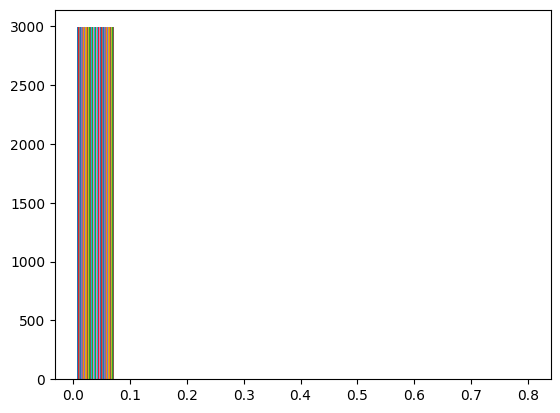

In [49]:
plt.hist(encoder_embds[D])

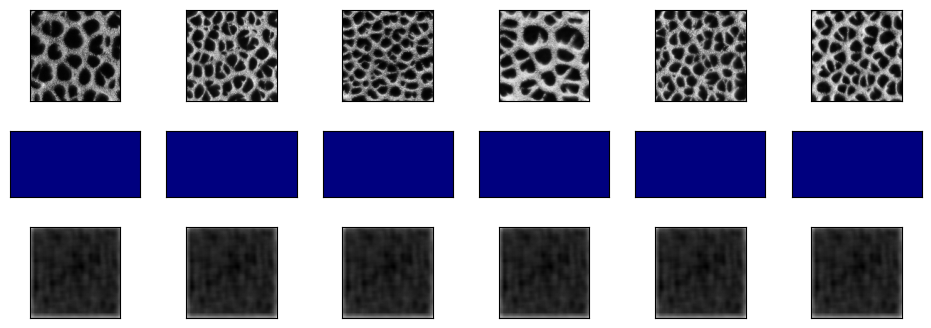

In [50]:
plt.figure(figsize=(40, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(data_train[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoder_embds[D][i].reshape(dmy,dmx),cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(autoencoder_imgs[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()

In [51]:
# Imágenes del Decoder (from encoder embeddings)
autoencoder_imgs_test = vae_decoder.predict(encoder_embds_test[D])
print(np.shape(autoencoder_imgs_test),np.shape(encoder_embds_test))

6/6 [==============================] - 0s 4ms/step
(184, 128, 128, 1) (3, 184, 128)


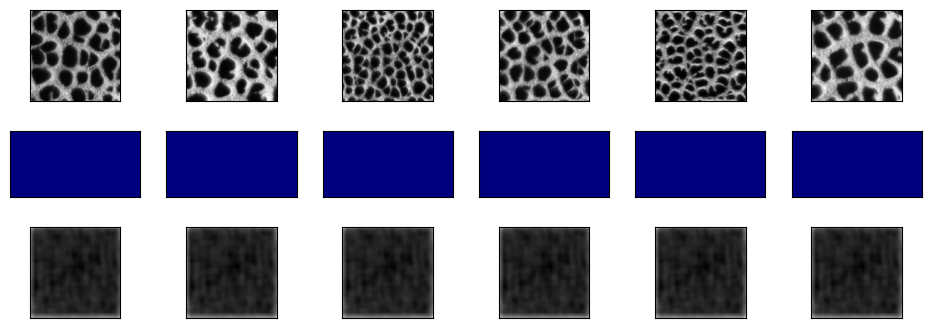

In [52]:
plt.figure(figsize=(40, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(data_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoder_embds_test[D][i].reshape(dmy,dmx),cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(autoencoder_imgs_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()

In [53]:
pca_data = PCA(n_components=2)
PCA_2dim = pca_data.fit_transform(encoder_embds[D])
PCA_2dim.shape

(2990, 2)

In [54]:
labels_text = pd.DataFrame(label_train).replace({0: "MF1", 1: "MF2",2: "MF3"})
labels_text.shape

(2990, 1)

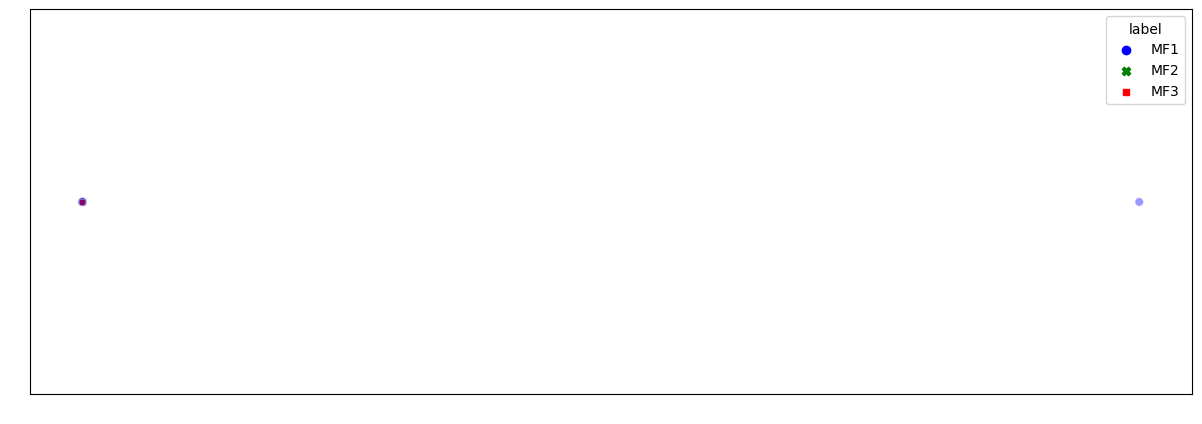

In [55]:
data_img = pd.DataFrame()                 
data_img['x'] = PCA_2dim[:,0]
data_img['y'] = PCA_2dim[:,1]
data_img['label'] = pd.DataFrame(labels_text)


plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img.x,y=data_img.y,hue='label',data=data_img, style='label',
            sizes=(60, 100), alpha=0.4, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=True)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xticks([])
plt.yticks([])
#plt.legend(fontsize="18")
#plt.xticks(range(-5, 5))
#plt.grid()

plt.show()

In [56]:
labels_text_test = pd.DataFrame(np.argmax(label_test,axis=1)).replace({0: "MF1", 1: "MF2",2: "MF3"})
labels_text_test.shape

(184, 1)

In [57]:
pca_data_test = PCA(n_components=2)
PCA_2dim_test = pca_data_test.fit_transform(encoder_embds_test[D])
PCA_2dim_test.shape

(184, 2)

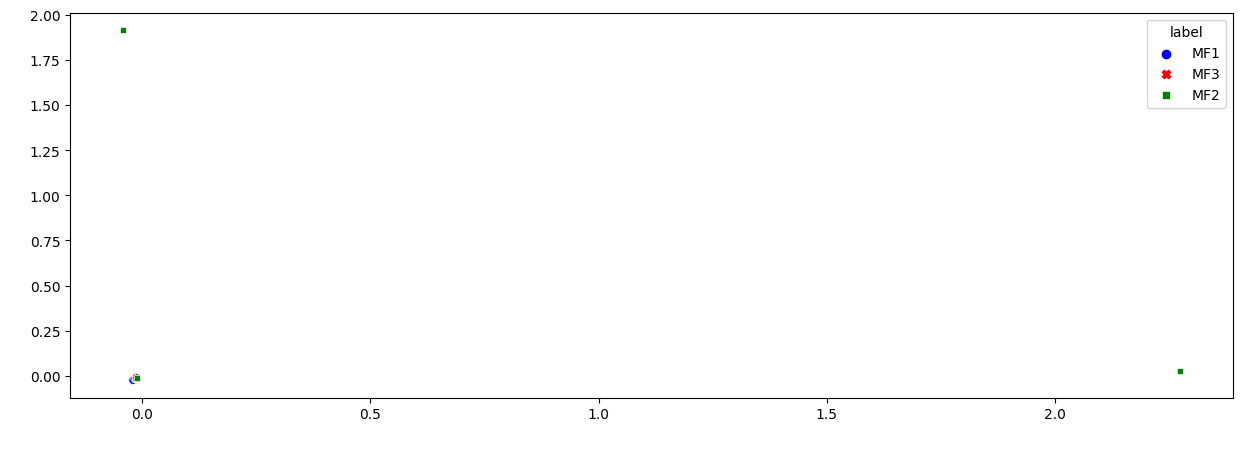

In [58]:
data_img_pca_test = pd.DataFrame()                 
data_img_pca_test['x'] = PCA_2dim_test[:,0]
data_img_pca_test['y'] = PCA_2dim_test[:,1]
data_img_pca_test['label'] = pd.DataFrame(labels_text_test)


sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='label',data=data_img_pca_test,style='label',
            sizes=(60, 100), alpha=1, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=True)
plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()